In [ ]:
''' Identify important content-level video features for each pipeline.
Challenge: 1. many features are highly correlated. how to reduce redundancy.
           2. identify "all" important features.
           
High-level description of our feature selection (two steps):
            1. Remove highly correlated features.
            2. Identify important features using different kinds of feature selection methods.
'''

In [2]:
import os
from collections import defaultdict
import glob
import sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel, SelectKBest, mutual_info_regression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor
from sklearn.linear_model import (LinearRegression, Ridge, 
								  Lasso)
from sklearn.feature_selection import RFE, f_regression
from sklearn.preprocessing import MinMaxScaler
from minepy import MINE
import operator
from mpl_toolkits.mplot3d import Axes3D
sys.path.append('../')
from pipeline_performance_loader import Parser, initialization, read_feature
from sklearn.base import BaseEstimator, TransformerMixin
from VIF import ReduceVIF
import seaborn as sns
from scipy.stats import pearsonr
from matplotlib import pyplot

In [3]:
# Create our function which stores the feature rankings to the ranks dictionary
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))


def rank_to_dict(ranks, names, order=1):
#     minmax = MinMaxScaler()
#     ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 2), ranks)
    return dict(zip(names, ranks ))

def topK_index(data, K):
    indices = data.argsort()[-1*K:][::-1]
    return indices, data[indices]

In [4]:
def feature_filtering(df, filter_method='pearson'):
	# remove correlated features
	if filter_method == 'VIF':
		# filter 
		transformer = ReduceVIF(thresh=5)
		df_filtered = transformer.fit_transform(df)
		return df_filtered
	elif filter_method == 'pearson':
		# filter feateures with pearson correlation higher than a thresh
		corr_matrix = df.corr()
		correlated_features = set()
		thresh = 0.8
		for i in range(len(corr_matrix.columns)):
			for j in range(i):
				if abs(corr_matrix.iloc[i, j]) > thresh:
					colname = corr_matrix.columns[i]
					correlated_features.add(colname)
		df_filtered = df.drop(correlated_features, axis=1)
		return df_filtered

	
	else:
		print('Filter method {} does not exist.'.format(filter_method))
		return df

In [5]:
# Load pipeline performance
all_feature_names, moving, video_to_delete, selected_video, glimpse_video_to_delete = initialization()
path = '/Users/zhujunxiao/Desktop/benchmarking/vldb/data/'
feature_file = path + 'allvideo_features_long.csv'
features = read_feature(feature_file)
glimpse_video_to_delete = []
glimpse_path = path + 'glimpse/glimpse_frame_select_results/'
glimpse_parser = Parser('glimpse', 
                         glimpse_path,
                         glimpse_video_to_delete,
                         moving)
glimpse_perf, moving_or_not = glimpse_parser.load_perf()

target_perf = glimpse_perf


Preprocessing starts (normalization, train_test_split)......
Preprocessing done!


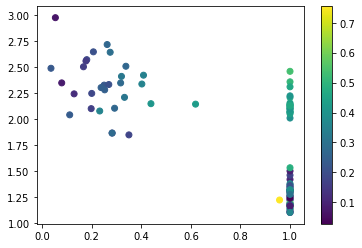

In [20]:

X = []
y = []
feature1 = []
feature2 = []
perf = []
X1 = []
X2 = []
y1 = []
y2 = []
for key in sorted(target_perf.keys()):
    if key not in features:
        continue

    # data cleaning
    if features[key][all_feature_names.index('object_cn_avg')] <= 0:
        continue
    if features[key][all_feature_names.index('velocity_avg')] < 1:
        continue
    if features[key][all_feature_names.index('object_size_avg')] <= 0:
        continue
    thresh1 = 0.05		
    if target_perf[key][1] < 0.9:
        continue
        
    #*********only for Glimpse*********#  
    # glimpse does not work well for moving videos, so has no correlation with percentage w/ objects
#     if moving_or_not[key] == 1:
#         continue 
        
        
    if features[key][all_feature_names.index('velocity_avg')] > 2: # or features[key][all_feature_names.index('velocity_avg')] > 1.3:
        X1.append(features[key])
        y1.append(target_perf[key][0])
        continue
    else:
        X2.append(features[key])
        y2.append(target_perf[key][0])
#     if features[key][all_feature_names.index('percentage')] > 0.5:
#         continue
#     if features[key][all_feature_names.index('object_size_avg')] >= 0.030:
#         print(key)
#         continue
    #*********************************#
    feature1.append(features[key][all_feature_names.index('percentage')])
    feature2.append(features[key][all_feature_names.index('velocity_avg')])
    perf.append(target_perf[key][0])
    

    
    X.append(features[key])
    y.append(target_perf[key][0])

tmp = np.random.choice(range(len(X2)), len(X1)).tolist()
X2_tmp = []
for index in tmp:
    X2_tmp.append(X2[index])
y2_tmp = np.random.choice(y2, len(y1)).tolist()

X_all = X1 + X2_tmp
y_all = y1 + y2_tmp
# plt.scatter(feature1, feature2, c=perf)  
plt.scatter([x[all_feature_names.index('percentage')] for x in X_all], [x[all_feature_names.index('velocity_avg')] for x in X_all], c=y_all)
plt.colorbar()
df = pd.DataFrame(X, columns=all_feature_names)
df['perf'] = y
# for name in all_feature_names:
#     plt.scatter(df[name], df['perf'])
#     print(pearsonr(df[name], df['perf'])) 
#     plt.title(name)
#     plt.show()
# preprocessing: standardization, and train test split
print('Preprocessing starts (normalization, train_test_split)......')
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)  
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, 
                                    test_size=0.2, random_state=0) 

print('Preprocessing done!')

In [21]:
# df = pd.DataFrame(X, columns=all_feature_names)
# df['perf'] = y

print(pearsonr([x[all_feature_names.index('velocity_avg')] for x in X_all], y_all))
# for name in names:
    
# plt.scatter(df['percentage'], df['perf'])

# plt.show()
# features = df.drop(['perf'], axis=1)

(0.09070476964023126, 0.3898504252328703)


After pearson correlation filtering, remaining features: Index(['object_cn_median', 'object_cn_var', 'object_cn_skewness',
       'object_cn_kurtosis', 'object_cn_entropy', 'object_size_median',
       'object_size_avg', 'object_size_mode', 'object_size_skewness',
       'object_size_percentile10', 'arrival_rate_median', 'arrival_rate_var',
       'arrival_rate_skewness', 'arrival_rate_entropy', 'velocity_median',
       'velocity_mode', 'velocity_var', 'velocity_skewness',
       'total_area_median', 'total_area_mode', 'total_area_var',
       'total_area_skewness', 'number_of_object_classes'],
      dtype='object')
ReduceVIF fit
ReduceVIF transform


/usr/local/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Dropping object_size_var with vif=inf
Dropping arrival_rate_iqr with vif=inf
Dropping arrival_rate_var with vif=inf
Dropping velocity_var with vif=inf
Dropping velocity_percentile75 with vif=inf
Dropping object_cn_var with vif=inf
Dropping object_cn_percentile25 with vif=inf
Dropping total_area_var with vif=inf
Dropping total_area_percentile25 with vif=inf
Dropping object_size_percentile75 with vif=2251799813685248.0
Dropping velocity_avg with vif=128324.93245966543
Dropping velocity_entropy with vif=37150.69278246935
Dropping total_area_entropy with vif=18334.4011452313
Dropping total_area_avg with vif=12896.767217257844
Dropping velocity_percentile25 with vif=9074.94361007295
Dropping object_cn_entropy with vif=6885.529799718802
Dropping object_cn_avg with vif=4895.95595564425
Dropping arrival_rate_avg with vif=3329.2455124049943
Dropping object_size_entropy with vif=3234.3193648043457
Dropping velocity_percentile10 with vif=1584.158692500199
Dropping object_size_avg with vif=1287.64

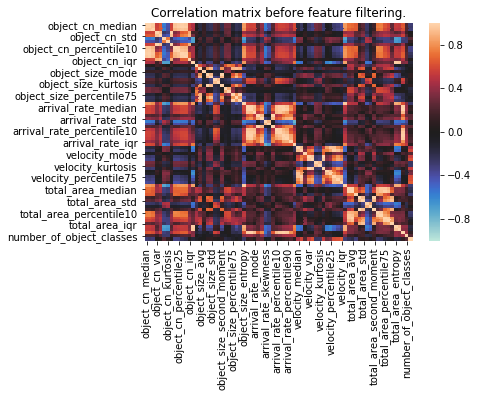

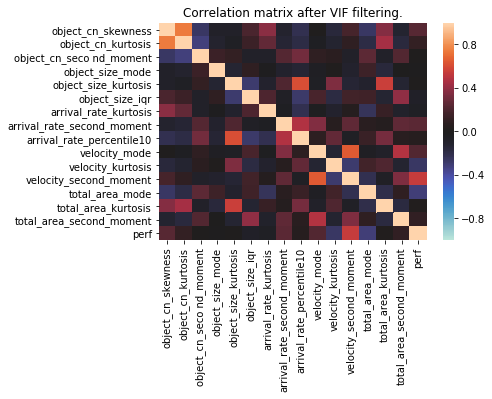

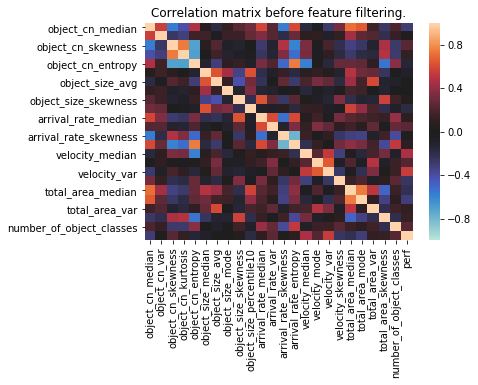

In [22]:
# remove correlated features, using two methods
df = pd.DataFrame(X, columns=all_feature_names)
df_filtered_pearson = feature_filtering(df)
print('After pearson correlation filtering, remaining features:', df_filtered_pearson.columns)
df_filtered_vif = feature_filtering(df, filter_method='VIF')
print('After VIF filtering, remaining features:', df_filtered_vif.columns)

# visualize correlation matrix before and after filtering
df['perf'] = y
df_filtered_pearson['perf'] = y
df_filtered_vif['perf'] = y

# f,(ax1,ax2,ax3) = plt.subplots(1,3,sharey=True)
cor = df.corr()
sns.heatmap(cor, vmin=-1, vmax=1, center=0)
plt.title('Correlation matrix before feature filtering.')
plt.show()
cor = df_filtered_vif.corr()
sns.heatmap(cor, vmin=-1, vmax=1, center=0)
plt.title('Correlation matrix after VIF filtering.')
plt.show()
cor = df_filtered_pearson.corr()
sns.heatmap(cor, vmin=-1, vmax=1, center=0)
plt.title('Correlation matrix before feature filtering.')
plt.show()	


In [23]:
# Implement multiple types of feature selection methods. And compare their selected results.

def select_good_features(X, Y, names, n_features_to_select=5):
    ranks = {}
    lr = LinearRegression(normalize=True)
    lr.fit(X, Y)
    ranks["Linear"] = rank_to_dict(np.abs(lr.coef_), names)

    ridge = Ridge(alpha=7)
    ridge.fit(X, Y)
    ranks["Ridge"] = rank_to_dict(np.abs(ridge.coef_), names)


    lasso = Lasso(alpha=.05)
    lasso.fit(X, Y)
    ranks["Lasso"] = rank_to_dict(np.abs(lasso.coef_), names)


    #stop the search when 5 features are left (they will get equal scores)
    rfe = RFE(lr, n_features_to_select=5)
    rfe.fit(X,Y)
    ranks["RFE"] = rank_to_dict(rfe.ranking_, names, order=-1)

    rf = RandomForestRegressor()
    rf.fit(X,Y)
    ranks["RF"] = rank_to_dict(rf.feature_importances_, names)


    f, pval  = f_regression(X, Y, center=True)
    ranks["Corr."] = rank_to_dict(f, names)

    mine = MINE()
    mic_scores = []
    for i in range(X.shape[1]):
        mine.compute_score(X[:,i], Y)
        m = mine.mic()
        mic_scores.append(m)

    ranks["MIC"] = rank_to_dict(mic_scores, names) 
    r = {}
    for name in names:
        r[name] = round(np.mean([ranks[method][name] 
                                 for method in ranks.keys()]), 2)

    methods = sorted(ranks.keys())
    ranks["Mean"] = r
    methods.append("Mean")

  

    # rank = [np.abs(x) for x in lr.feature_importances_]
    # indicies = topK_index(np.asarray(rank), 3)

    # for i in indicies[0]:
    # 	print(all_feature_names[i])

    return methods, ranks





In [24]:
features = df.drop(['perf'], axis=1)
X = features.as_matrix()
Y = df['perf']
names = features.columns.values
print('The shape of feature matrix:', X.shape)
# print('all feature names:', names)
methods, ranks = select_good_features(X, Y, names, n_features_to_select=5)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


The shape of feature matrix: (285, 73)


In [25]:
print("%30s\t%s" % ('Feature name', "\t".join(methods)))
for name in names:
    print("%30s\t%s" % (name, "\t".join(map(str, 
                         [ranks[method][name] for method in methods])))) 

                  Feature name	Corr.	Lasso	Linear	MIC	RF	RFE	Ridge	Mean
              object_cn_median	28.0	0.01	0.04	0.24	0.0	31	0.03	8.47
                 object_cn_avg	23.63	0.0	0.09	0.23	0.0	30	0.04	7.71
                object_cn_mode	27.71	0.0	0.0	0.24	0.0	58	0.0	12.28
                 object_cn_var	0.02	0.0	151878829283.42	0.31	0.0	44	0.0	21696975618.25
                 object_cn_std	0.66	0.0	0.1	0.31	0.0	39	0.04	5.73
            object_cn_skewness	16.94	0.0	0.0	0.21	0.01	67	0.01	12.02
            object_cn_kurtosis	3.46	0.0	0.0	0.2	0.01	56	0.0	8.52
      object_cn_seco nd_moment	0.02	0.0	151878829283.43	0.31	0.0	49	0.0	21696975618.97
        object_cn_percentile10	34.43	0.0	0.0	0.28	0.0	69	0.01	14.82
        object_cn_percentile25	32.89	0.0	69129979508.12	0.26	0.0	48	0.0	9875711369.9
        object_cn_percentile75	18.69	0.0	69129979508.11	0.25	0.0	40	0.01	9875711366.72
        object_cn_percentile90	12.95	0.0	0.01	0.23	0.0	47	0.01	8.6
                 object_cn_iqr	0.32	0.0	6912

In [26]:
for method in methods:
    new_rank = {k: v for k, v in sorted(ranks[method].items(), key=lambda item: item[1], reverse=True)}
    rank_iterator = iter(new_rank)
    print('Selected features of method {}:'.format(method))
    for i in range(3):
        selected_feature = next(rank_iterator)
        feature_importance = new_rank[selected_feature]
        print(selected_feature, feature_importance)


Selected features of method Corr.:
velocity_iqr 220.19
velocity_std 181.12
velocity_percentile90 169.74
Selected features of method Lasso:
object_cn_median 0.01
object_cn_avg 0.0
object_cn_mode 0.0
Selected features of method Linear:
object_size_var 84590637912630.4
object_size_second_moment 84590637912587.28
total_area_var 37786415999377.85
Selected features of method MIC:
velocity_percentile90 0.63
velocity_avg 0.62
velocity_iqr 0.61
Selected features of method RF:
velocity_iqr 0.32
velocity_percentile90 0.16
velocity_avg 0.05
Selected features of method RFE:
object_cn_percentile10 69
object_size_kurtosis 68
object_cn_skewness 67
Selected features of method Ridge:
arrival_rate_entropy 0.07
velocity_iqr 0.06
velocity_std 0.05
Selected features of method Mean:
object_size_var 12084376844663.53
object_size_second_moment 12084376844658.52
total_area_var 5398059428484.21


In [27]:
features = df_filtered_pearson.drop(['perf'], axis=1)
X = features.as_matrix()
Y = df_filtered_pearson['perf']
names = features.columns.values
print('The shape of feature matrix:', X.shape)
print('all feature names:', names)
methods, ranks = select_good_features(X, Y, names, n_features_to_select=5)


The shape of feature matrix: (285, 23)
all feature names: ['object_cn_median' 'object_cn_var' 'object_cn_skewness'
 'object_cn_kurtosis' 'object_cn_entropy' 'object_size_median'
 'object_size_avg' 'object_size_mode' 'object_size_skewness'
 'object_size_percentile10' 'arrival_rate_median' 'arrival_rate_var'
 'arrival_rate_skewness' 'arrival_rate_entropy' 'velocity_median'
 'velocity_mode' 'velocity_var' 'velocity_skewness' 'total_area_median'
 'total_area_mode' 'total_area_var' 'total_area_skewness'
 'number_of_object_classes']


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [28]:
print("%30s\t%s" % ('Feature name', "\t".join(methods)))
for name in names:
    print("%30s\t%s" % (name, "\t".join(map(str, 
                         [ranks[method][name] for method in methods])))) 

                  Feature name	Corr.	Lasso	Linear	MIC	RF	RFE	Ridge	Mean
              object_cn_median	28.0	0.01	0.02	0.24	0.0	10	0.02	5.47
                 object_cn_var	0.02	0.0	0.01	0.31	0.01	12	0.01	1.77
            object_cn_skewness	16.94	0.0	0.04	0.21	0.02	7	0.03	3.46
            object_cn_kurtosis	3.46	0.0	0.0	0.2	0.02	15	0.0	2.67
             object_cn_entropy	5.54	0.0	0.02	0.32	0.01	8	0.0	1.98
            object_size_median	1.83	0.0	1.85	0.26	0.03	1	0.0	0.71
               object_size_avg	0.03	0.0	2.29	0.21	0.07	1	0.0	0.51
              object_size_mode	0.02	0.0	4.15	0.23	0.02	1	0.0	0.77
          object_size_skewness	0.52	0.0	0.0	0.29	0.03	18	0.0	2.69
      object_size_percentile10	9.19	0.0	2.02	0.25	0.03	1	0.0	1.78
           arrival_rate_median	2.06	0.0	0.0	0.22	0.01	17	0.0	2.76
              arrival_rate_var	18.45	0.0	0.0	0.27	0.02	16	0.0	4.96
         arrival_rate_skewness	0.02	0.0	0.0	0.24	0.03	19	0.01	2.76
          arrival_rate_entropy	1.96	0.0	0.11	0.21	0.02	6	0.09	1

In [29]:
for method in methods:
    new_rank = {k: v for k, v in sorted(ranks[method].items(), key=lambda item: item[1], reverse=True)}
    rank_iterator = iter(new_rank)
    print('Selected features of method {}:'.format(method))
    for i in range(3):
        selected_feature = next(rank_iterator)
        feature_importance = new_rank[selected_feature]
        print(selected_feature, feature_importance)

Selected features of method Corr.:
velocity_var 120.44
velocity_median 79.23
total_area_mode 29.09
Selected features of method Lasso:
object_cn_median 0.01
object_cn_var 0.0
object_cn_skewness 0.0
Selected features of method Linear:
object_size_mode 4.15
object_size_avg 2.29
object_size_percentile10 2.02
Selected features of method MIC:
velocity_median 0.46
velocity_var 0.46
object_cn_entropy 0.32
Selected features of method RF:
velocity_var 0.41
velocity_median 0.12
object_size_avg 0.07
Selected features of method RFE:
arrival_rate_skewness 19
object_size_skewness 18
arrival_rate_median 17
Selected features of method Ridge:
velocity_var 0.14
velocity_median 0.11
arrival_rate_entropy 0.09
Selected features of method Mean:
velocity_var 17.95
velocity_median 11.88
object_cn_median 5.47


In [30]:
features = df_filtered_vif.drop(['perf'], axis=1)
X = features.as_matrix()
Y = df_filtered_vif['perf']
names = features.columns.values
print('The shape of feature matrix:', X.shape)
print('all feature names:', names)
methods, ranks = select_good_features(X, Y, names, n_features_to_select=5)


The shape of feature matrix: (285, 15)
all feature names: ['object_cn_skewness' 'object_cn_kurtosis' 'object_cn_seco nd_moment'
 'object_size_mode' 'object_size_kurtosis' 'object_size_iqr'
 'arrival_rate_kurtosis' 'arrival_rate_second_moment'
 'arrival_rate_percentile10' 'velocity_mode' 'velocity_kurtosis'
 'velocity_second_moment' 'total_area_mode' 'total_area_kurtosis'
 'total_area_second_moment']


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [31]:
print("%30s\t%s" % ('Feature name', "\t".join(methods)))
for name in names:
    print("%30s\t%s" % (name, "\t".join(map(str, 
                         [ranks[method][name] for method in methods])))) 

                  Feature name	Corr.	Lasso	Linear	MIC	RF	RFE	Ridge	Mean
            object_cn_skewness	16.94	0.0	0.06	0.21	0.03	2	0.07	2.76
            object_cn_kurtosis	3.46	0.0	0.01	0.2	0.03	4	0.01	1.1
      object_cn_seco nd_moment	0.02	0.0	0.0	0.31	0.05	6	0.0	0.91
              object_size_mode	0.02	0.0	2.8	0.23	0.03	1	0.0	0.58
          object_size_kurtosis	0.06	0.0	0.0	0.3	0.05	11	0.0	1.63
               object_size_iqr	1.59	0.0	1.47	0.21	0.06	1	0.01	0.62
         arrival_rate_kurtosis	1.06	0.0	0.01	0.17	0.05	5	0.01	0.9
    arrival_rate_second_moment	18.45	0.0	0.0	0.27	0.05	7	0.0	3.68
     arrival_rate_percentile10	0.65	0.0	0.0	0.27	0.01	8	0.0	1.28
                 velocity_mode	14.25	0.0	0.02	0.29	0.02	3	0.01	2.51
             velocity_kurtosis	20.31	0.0	0.0	0.22	0.03	10	0.0	4.37
        velocity_second_moment	120.44	0.0	0.37	0.46	0.45	1	0.21	17.56
               total_area_mode	29.09	0.0	0.55	0.29	0.03	1	0.06	4.43
           total_area_kurtosis	0.23	0.0	0.0	0.23	0.05	9	0.0	1.3

In [32]:
for method in methods:
    new_rank = {k: v for k, v in sorted(ranks[method].items(), key=lambda item: item[1], reverse=True)}
    rank_iterator = iter(new_rank)
    print('Selected features of method {}:'.format(method))
    for i in range(3):
        selected_feature = next(rank_iterator)
        feature_importance = new_rank[selected_feature]
        print(selected_feature, feature_importance)

Selected features of method Corr.:
velocity_second_moment 120.44
total_area_mode 29.09
velocity_kurtosis 20.31
Selected features of method Lasso:
object_cn_skewness 0.0
object_cn_kurtosis 0.0
object_cn_seco nd_moment 0.0
Selected features of method Linear:
object_size_mode 2.8
object_size_iqr 1.47
total_area_mode 0.55
Selected features of method MIC:
velocity_second_moment 0.46
object_cn_seco nd_moment 0.31
object_size_kurtosis 0.3
Selected features of method RF:
velocity_second_moment 0.45
total_area_second_moment 0.07
object_size_iqr 0.06
Selected features of method RFE:
object_size_kurtosis 11
velocity_kurtosis 10
total_area_kurtosis 9
Selected features of method Ridge:
velocity_second_moment 0.21
object_cn_skewness 0.07
total_area_mode 0.06
Selected features of method Mean:
velocity_second_moment 17.56
total_area_mode 4.43
velocity_kurtosis 4.37


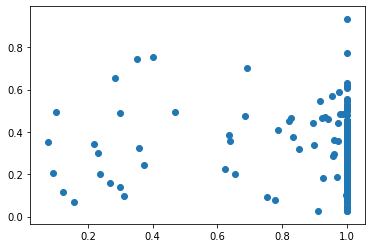

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


[('velocity_iqr', 0.6615019069306297), ('velocity_std', 0.6246931762532163), ('velocity_percentile90', 0.6123050440873572), ('velocity_percentile75', 0.5994363759581894), ('velocity_avg', 0.5818984400938422), ('velocity_var', 0.5463889392349285), ('velocity_second_moment', 0.5463889392349285), ('velocity_median', 0.46768641790022275), ('velocity_percentile25', 0.33569772520245866), ('object_cn_median', -0.3000624933746737), ('total_area_mode', -0.30531779429928246), ('object_cn_percentile25', -0.32269261616945866), ('object_cn_percentile10', -0.3293555537192282)]
Final selected feature: ['velocity_iqr', 'velocity_var', 'velocity_second_moment', 'velocity_median', 'velocity_percentile25', 'object_cn_median', 'total_area_mode', 'object_cn_percentile25', 'object_cn_percentile10']


In [33]:
from scipy.stats import pearsonr
from matplotlib import pyplot

plt.scatter(df['percentage'], df['perf'])
plt.show()
features = df.drop(['perf'], axis=1)
X = features.as_matrix()
Y = df['perf']
names = features.columns.values
score = mutual_info_regression(X, Y)
rank = [sorted(score, reverse=True).index(x) for x in score]

names = features.columns.values
correlation_thresh = 0.3
correlated_features = []
for name in names:
    (r, p) = pearsonr(df[name], df['perf'])
    if np.abs(r) > correlation_thresh:
        correlated_features.append((name,r))
correlated_features.sort(key=lambda x: x[1], reverse=True)
print(correlated_features)
selected_features = [correlated_features[0][0]]
for feature in correlated_features[1:]:
    (r, p) = pearsonr(df[feature[0]], df[correlated_features[0][0]])
    if np.abs(r) <= 0.8:
        selected_features.append(feature[0])
print('Final selected feature:', selected_features)